In [1]:
import polars as pl
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from src.util.constants import PATH_RAW_TRAIN_SET, PATH_RAW_VALIDATE_SET, PATH_RAW_META_MODEL, FIXED_LGB_PARAMETERS
from src.util.common import grouped_spearman_correlation, orthogonalise_by_era

In [2]:
df_train = pl.read_parquet(PATH_RAW_TRAIN_SET)
df_validate = pl.read_parquet(PATH_RAW_VALIDATE_SET)
df_meta_model = pl.read_parquet(PATH_RAW_META_MODEL)

df_meta_model = df_meta_model.drop(['era', 'data_type'])
df_meta_model = df_meta_model.join(df_validate, on='id', how='inner')
del df_validate

feature_names = [x for x in df_train.columns if 'feature' in x]

In [3]:
print(f"Number of meta-model eras: {len(df_meta_model['era'].unique())}")

Number of meta-model eras: 64


In [4]:
num_boost_round_space = [10, 50, 200]
num_leaves_space = [2**(x*2) - 1 for x in range(2, 7)]

In [5]:
# runs for ca. 1h

corr_pred_pred_mm_by_era_list = []
corr_pred_target_by_era_list = []
corr_pred_ortho_target_by_era_list = []

for num_boost_round in num_boost_round_space:
    for num_leaves in num_leaves_space:
        parameters = {
            **FIXED_LGB_PARAMETERS,
            'num_leaves': num_leaves,
            'num_boost_round': num_boost_round
        }

        lgb_train = lgb.Dataset(df_train[feature_names].to_numpy(), label=df_train['target'].to_numpy())

        model = lgb.train(
            params=parameters,
            train_set=lgb_train,
            num_boost_round=parameters['num_boost_round']
        )

        df_meta_model_with_prediction = df_meta_model.with_columns(
            prediction=pl.Series(model.predict(df_meta_model[feature_names].to_numpy()))
        )

        corr_pred_pred_mm_by_era = df_meta_model_with_prediction.select(
            pl.corr("prediction", "numerai_meta_model", method="spearman").over('era', mapping_strategy='explode')
        )
        corr_pred_pred_mm_by_era_list.append(corr_pred_pred_mm_by_era)

        corr_pred_target_by_era = grouped_spearman_correlation(
            df_meta_model_with_prediction['prediction'],
            df_meta_model_with_prediction['target'],
            df_meta_model_with_prediction['era']
        )
        corr_pred_target_by_era_list.append(corr_pred_target_by_era)

        df_meta_model_with_prediction = df_meta_model_with_prediction.with_columns(
            prediction_orthogonalised=orthogonalise_by_era(
                df_meta_model_with_prediction['prediction'],
                df_meta_model_with_prediction['numerai_meta_model'],
                df_meta_model_with_prediction['era']
            )
        )

        corr_pred_ortho_target_by_era = grouped_spearman_correlation(
            df_meta_model_with_prediction['prediction_orthogonalised'],
            df_meta_model_with_prediction['target'],
            df_meta_model_with_prediction['era']
        )
        corr_pred_ortho_target_by_era_list.append(corr_pred_ortho_target_by_era)

        print(f'{datetime.now().strftime("%H:%M:%S")} . . . Training and evaluating model for num_leaves={num_leaves} and num_boost_round={num_boost_round} done.')

19:53:14 . . . Training and evaluating model for num_leaves=15 and num_boost_round=10 done.
19:54:58 . . . Training and evaluating model for num_leaves=63 and num_boost_round=10 done.
19:56:43 . . . Training and evaluating model for num_leaves=255 and num_boost_round=10 done.
19:58:37 . . . Training and evaluating model for num_leaves=1023 and num_boost_round=10 done.
20:01:21 . . . Training and evaluating model for num_leaves=4095 and num_boost_round=10 done.
20:04:42 . . . Training and evaluating model for num_leaves=15 and num_boost_round=50 done.
20:08:34 . . . Training and evaluating model for num_leaves=63 and num_boost_round=50 done.
20:13:03 . . . Training and evaluating model for num_leaves=255 and num_boost_round=50 done.
20:18:11 . . . Training and evaluating model for num_leaves=1023 and num_boost_round=50 done.
20:25:19 . . . Training and evaluating model for num_leaves=4095 and num_boost_round=50 done.
20:33:03 . . . Training and evaluating model for num_leaves=15 and num

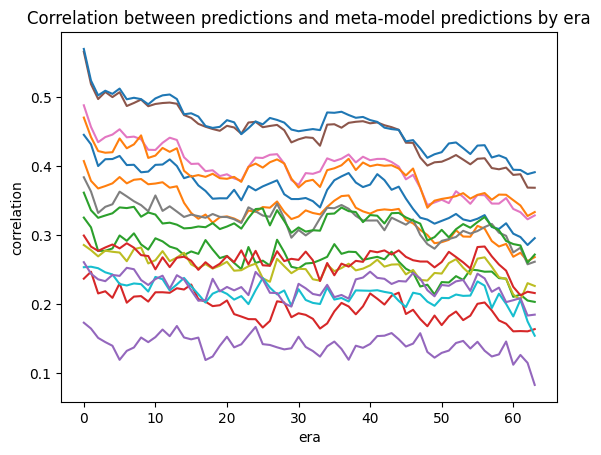

In [6]:
for series in corr_pred_pred_mm_by_era_list:
    plt.plot(series)
plt.xlabel('era')
plt.ylabel('correlation')
plt.title('Correlation between predictions and meta-model predictions by era')
plt.show()

Correlation with the meta model is quite stable over the eras but tends to decrease over time.

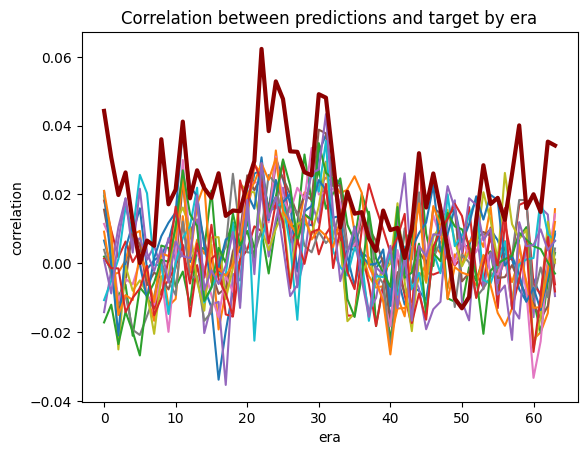

In [7]:
for series in corr_pred_target_by_era_list:
    plt.plot(series)

# add meta model performance
corr_pred_mm_target_by_era = grouped_spearman_correlation(df_meta_model['numerai_meta_model'], df_meta_model['target'], df_meta_model['era'])

plt.plot(corr_pred_mm_target_by_era, color='darkred', linewidth=3)
plt.xlabel('era')
plt.ylabel('correlation')
plt.title('Correlation between predictions and target by era')
plt.show()

The meta model outperforms the individual models.

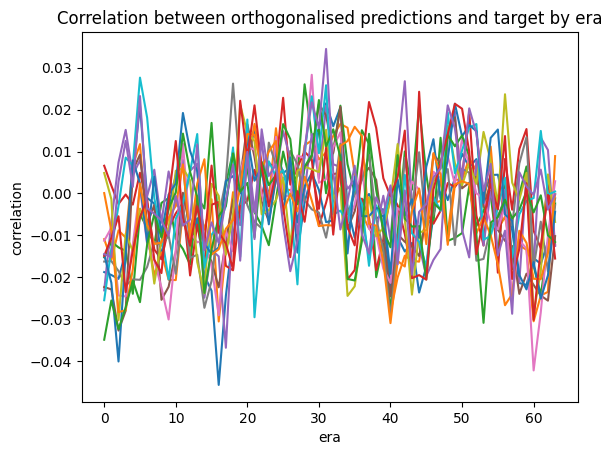

In [8]:
for series in corr_pred_ortho_target_by_era_list:
    plt.plot(series)
plt.xlabel('era')
plt.ylabel('correlation')
plt.title('Correlation between orthogonalised predictions and target by era')
plt.show()

Correlation between the model and the meta model seems quite stable (much more stable than correlation with the target).
This means we may use correlation with the meta model even on our small sample for which we have meta-model predictions.

First idea for MMC approximation: CORR_PRED_TARGET - (CORR_PRED_MM * CORR_MM_TARGET)

In [9]:
mmc_approx_list = []
corr_pred_ortho_target_list = []

for i in range(len(num_boost_round_space) * len(num_leaves_space)):  # number of models
    corr_pred_target = corr_pred_target_by_era_list[i]
    corr_pred_mm = corr_pred_pred_mm_by_era_list[i].to_series()

    mmc_approx = corr_pred_target - (corr_pred_mm * corr_pred_mm_target_by_era)
    mmc_approx_list.extend(mmc_approx)

    corr_pred_ortho_target_list.extend(corr_pred_ortho_target_by_era_list[i])

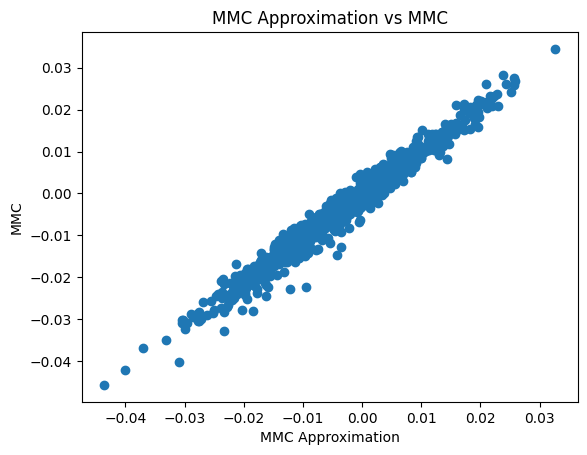

In [10]:
plt.scatter(mmc_approx_list, corr_pred_ortho_target_list)
plt.xlabel('MMC Approximation')
plt.ylabel('MMC')
plt.title('MMC Approximation vs MMC')
plt.show()

In [11]:
correlation = np.corrcoef(mmc_approx_list, corr_pred_ortho_target_list)[0, 1]
print(f'Correlation between CORR_PRED_TARGET - (CORR_PRED_MM * CORR_MM_TARGET) and MMC: {correlation:.4f}')

Correlation between CORR_PRED_TARGET - (CORR_PRED_MM * CORR_MM_TARGET) and MMC: 0.9855


CORR_PRED_Y - (CORR_PRED_MM * CORR_MM_TARGET) is a fantastic approximation for MMC!

We can use CORR_PRED_MM on the small number of eras we have of the meta model and approximate CORR_MM_TARGET on eras for which we don't have the meta-model predictions by using the ratio of the median model performance and the meta model performance on the meta-model eras.